# Introduction
- The goal of this section is to train a convolutional neural network on custom images (radiographss) from scratch. To achieve this, there are few operations we need to perform, which includes:
  - Connecting google colab to our google drive
  - Data Preparation: creating training and test data from the raw data
  - Building the CNN architecture
  - Training the network with and without transfer learning using pretrained models such as Vgg16, ResNet50, DenseNet121, MobileNetV1 and EfficientNet


- Dataset:https://stanfordmlgroup.github.io/competitions/mura/

In [ ]:
# Connect Google Colab to Google Drive
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
# install opencv-python
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# install keras-tuner

!pip install keras-tuner


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# smalldataset 256 multiclass train-test split

In [3]:
# import the required libraries
import cv2
import numpy as np
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [5]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# Smalldata 256 multiclass gridsearch (VGG16)

Found 686 images belonging to 7 classes.
Found 294 images belonging to 7 classes.
Found 420 images belonging to 7 classes.
Epoch 1/10
22/22 [==============================] - 2590s 120s/step - loss: 4.7342 - accuracy: 0.2362 - val_loss: 1.5229 - val_accuracy: 0.4592
Epoch 2/10
22/22 [==============================] - 2833s 130s/step - loss: 1.3519 - accuracy: 0.4869 - val_loss: 1.1893 - val_accuracy: 0.5952
Epoch 3/10
22/22 [==============================] - 2663s 122s/step - loss: 1.1353 - accuracy: 0.5933 - val_loss: 1.0251 - val_accuracy: 0.6735
Epoch 4/10
22/22 [==============================] - 2639s 121s/step - loss: 0.9343 - accuracy: 0.6924 - val_loss: 0.9029 - val_accuracy: 0.6837
Epoch 5/10
22/22 [==============================] - 2789s 129s/step - loss: 0.7042 - accuracy: 0.7755 - val_loss: 0.8021 - val_accuracy: 0.7415
Epoch 6/10
22/22 [==============================] - 2647s 122s/step - loss: 0.6032 - accuracy: 0.8134 - val_loss: 0.8725 - val_accuracy: 0.6939
Epoch 7/10
22

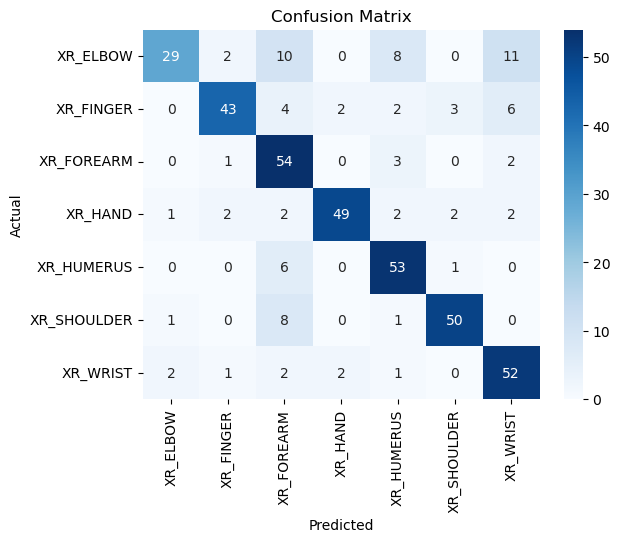

Sensitivity: [0.48333333 0.71666667 0.9        0.81666667 0.88333333 0.83333333
 0.86666667]
Specificity: [0.87878788 0.87755102 0.62790698 0.9245283  0.75714286 0.89285714
 0.71232877]


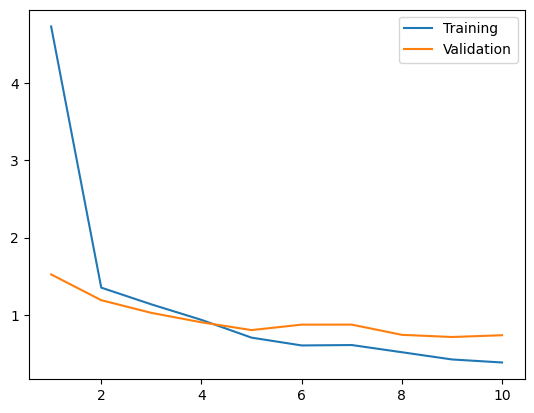

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/test"


# Data Preprocessing
image_size = (256, 256)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze base model

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Visualize the loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.legend(loc="best")
plt.show()

# Smalldata 256 multiclass 5CV (VGG16)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/test"

# Data Preprocessing
image_size = (256, 256)
batch_size = 32
cv_folds = 5

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Training fold 1/5
Found 686 images belonging to 7 classes.
Found 294 images belonging to 7 classes.
Epoch 1/10
22/22 [==============================] - 3342s 156s/step - loss: 5.8511 - accuracy: 0.2172 - val_loss: 1.5065 - val_accuracy: 0.4728
Epoch 2/10
22/22 [==============================] - 6430s 295s/step - loss: 1.5705 - accuracy: 0.4009 - val_loss: 1.3561 - val_accuracy: 0.5272
Epoch 3/10
22/22 [==============================] - 9513s 444s/step - loss: 1.2722 - accuracy: 0.5233 - val_loss: 1.2067 - val_accuracy: 0.5510
Epoch 4/10
22/22 [==============================] - 4852s 223s/step - loss: 0.9932 - accuracy: 0.6603 - val_loss: 1.0237 - val_accuracy: 0.6701
Epoch 5/10
22/22 [==============================] - 6776s 312s/step - loss: 0.9216 - accuracy: 0.6720 - val_loss: 0.9822 - val_accuracy: 0.6599
Epoch 6/10
22/22 [==============================] - 6170s 283s/step - loss: 0.8043 - accuracy: 0.7420 - val_loss: 0.8578 - val_accuracy: 0.7143
Epoch 7/10
22/22 [==================

# Smalldata 256 multiclass 10CV (VGG16)

Training fold 1/10
Found 686 images belonging to 7 classes.
Found 294 images belonging to 7 classes.
Epoch 1/10
22/22 [==============================] - 801s 36s/step - loss: 1.8421 - accuracy: 0.3149 - val_loss: 1.3300 - val_accuracy: 0.5136
Epoch 2/10
22/22 [==============================] - 920s 42s/step - loss: 1.2793 - accuracy: 0.5175 - val_loss: 1.1859 - val_accuracy: 0.5612
Epoch 3/10
22/22 [==============================] - 2667s 125s/step - loss: 1.0161 - accuracy: 0.6429 - val_loss: 1.1136 - val_accuracy: 0.6054
Epoch 4/10
22/22 [==============================] - 416s 19s/step - loss: 0.9343 - accuracy: 0.6676 - val_loss: 1.0085 - val_accuracy: 0.6463
Epoch 5/10
22/22 [==============================] - 532s 25s/step - loss: 0.8128 - accuracy: 0.7070 - val_loss: 0.9687 - val_accuracy: 0.6769
Epoch 6/10
22/22 [==============================] - 727s 34s/step - loss: 0.7495 - accuracy: 0.7347 - val_loss: 0.9679 - val_accuracy: 0.6565
Epoch 7/10
22/22 [===========================

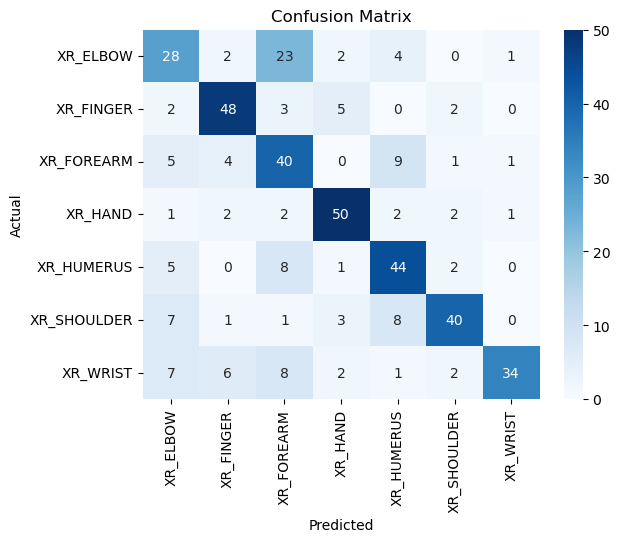

Sensitivity: [0.46666667 0.8        0.66666667 0.83333333 0.73333333 0.66666667
 0.56666667]
Specificity: [0.50909091 0.76190476 0.47058824 0.79365079 0.64705882 0.81632653
 0.91891892]


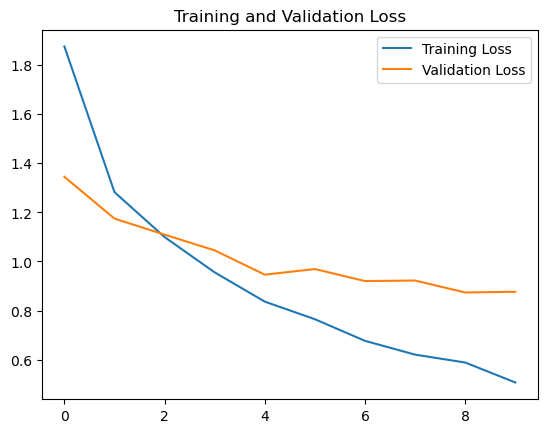

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/256/Multiclass/test"

# Data Preprocessing
image_size = (256, 256)
batch_size = 32
cv_folds = 10

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()